In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K
import sys
import datetime
from tensorflow.python.client import device_lib

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# Model to test with 'enough statistics' root file
model_name = 'model-2b-lsr'

shuffle_clusters = False

# load the training data
data = DataModel('data-enough-8cl.npz', 
                 batch_size = 128, validation_percent = .05, test_percent = .1)
                 
# append an extra dimension to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 2
ai.weight_pos_x = 2.5
ai.weight_pos_y = 1
ai.weight_pos_z = 2
ai.weight_energy = 1.5
ai.weight_e_cluster = 1
ai.weight_p_cluster = 1


# randomly shuffle the training data
#np.random.seed(888)
#ai.data.shuffle(only_train=False)

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [3]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.0001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [4]:
# compile the ai
ai.compile_model(learning_rate=0.0003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 90:
        return .0003
    elif epoch < 160:
        return .0001
    elif epoch < 180:
        return .00003
    elif epoch < 190:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler)
]

In [5]:
# Load a trained model from folder ModelsTrained
ai.load(file_name = model_name)

# Evaluation
Using some evaluation functions to get insights in the MC truth data and the model predictions

In [6]:
ai.evaluate()

AI model
  Loss:        3.45655
    -Type:         0.27309 *  2.00 = 0.54619
    -Pos X:        0.03541 *  2.50 = 0.08854
    -Pos Y:        1.08336 *  1.00 = 1.08336
    -Pos Z:        0.04034 *  2.00 = 0.08067
    -Energy:       0.96894 *  1.50 = 1.45340
    -Cls e:        0.03097 *  1.00 = 0.03097
    -Cls p:        0.07578 *  1.00 = 0.07578
  Accuracy:    0.88271
    -TP rate:      0.83581
    -Cls e rate:   0.95581
    -Cls p rate:   0.89239
  Efficiency:  0.15017
  Purity:      0.13774
  Euc mean:   11.10979
  Euc std:    29.15231

Reco
  Accuracy:    0.64432
    -TP rate:      0.75151
  Efficiency:  0.10441
  Purity:      0.05890
  Euc mean:   20.92661
  Euc std:    49.07857


In [7]:
ai.evaluation_positions(mask = 'type', data = 'prediction')

min_x_scat : 193.5
max_x_scat : 206.5
min_x_abs : 380.5
max_x_abs : 419.5
min_y : -50.0
max_y : 50.0
min_z : -49.4
max_z : 49.4
     15378 Events (matched)

     14859 Events e predicted inside scatterer
       442 Events e predicted inside absorber
        77 Events e pred. outside of volumes
  0.5007 Percent of outside pred. from all (matched) events

        54 ( 70.1299 %) x missed, e-
         0 (  0.0000 %) y missed, e-
        23 ( 29.8701 %) z missed, e-

       440 Events ph predicted inside scatterer,
     14726 Events ph predicted inside absorber
       212 Events ph outside of volumes
  1.3786 Percent of hits from all (matched) events

       128 ( 60.3774 %) x missed, photon
        45 ( 21.2264 %) y missed, photon
        42 ( 19.8113 %) z missed, photon


In [8]:
?ai.evaluation_positions

In [ ]:
?ai.evaluation_cones

In [9]:
ai.savefigpath = '/home/home2/institut_3b/profe/Data/SiFiCCNN/OldSim/model-2b-lsr/Cones/'

Check argument of arccos: Invalid events 123  from  15378
  Number of valid events (arccos): 15255.00000
  Number of valid events (arccos): 7412.00000       
  Number of valid events (arccos):  0.00000       
  Sanity check (No. y_OM larger y_OC): 7412.00000   
  No. axis missed, pos y_OC, 0 tolerance:  0.00000
  No. axis missed, pos y_OC, 5 tolerance:  0.00000
  No. axis missed, pos y_OC, 8 tolerance:  0.00000
  No. axis missed, pos y_OC, 10 tolerance:  0.00000
  No. axis missed, pos y_OC, 12 tolerance:  0.00000
  No. axis missed, pos y_OC, 20 tolerance:  0.00000
  No. axis missed, neg y_OC, 0 tolerance: 422.00000
  No. axis missed, neg y_OC, 5 tolerance: 94.00000
  No. axis missed, neg y_OC, 8 tolerance: 56.00000
  No. axis missed, neg y_OC, 10 tolerance: 41.00000
  No. axis missed, neg y_OC, 12 tolerance: 30.00000
  No. axis missed, neg y_OC, 20 tolerance: 11.00000


No handles with labels found to put in legend.


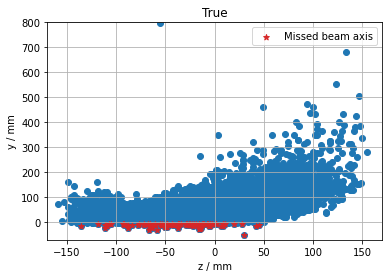

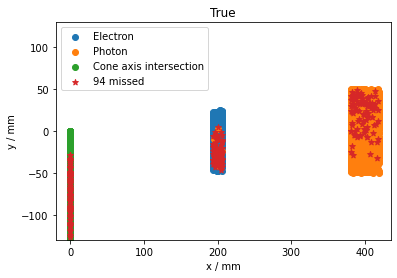

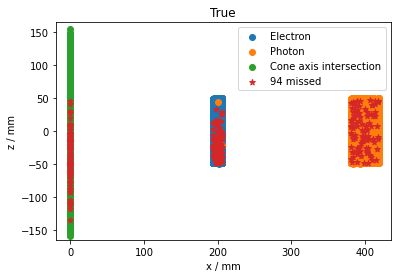

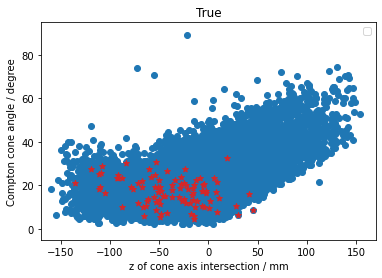

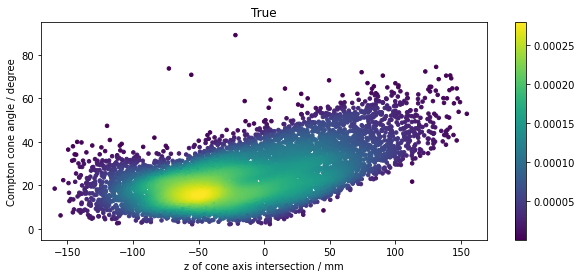

In [10]:
ai.evaluation_cones(mask = 'type', events = 'True', save = True)

In [11]:
?ai.events_prediction_analysis

 0.15017 Total efficiency
 0.13774 Total purity
 65668 All valid events
  2763 Correctly recon./ident. events
 18399 All true Compton events
 20059 NN pred Compton events
 15378 NN type-matched events
   12615 Type matched, pos energy mismatched 
    9248 Type and pos matched 
    4048 Type and energy matched 


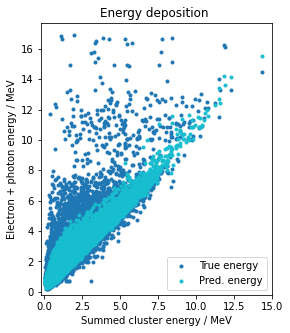

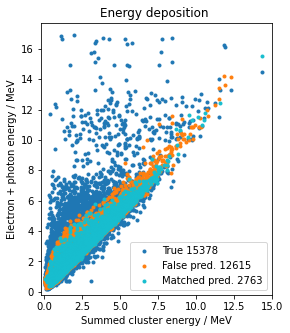

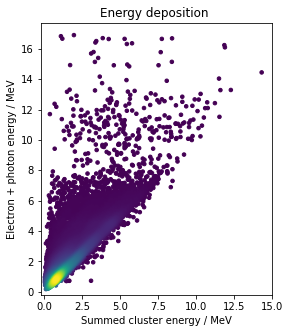

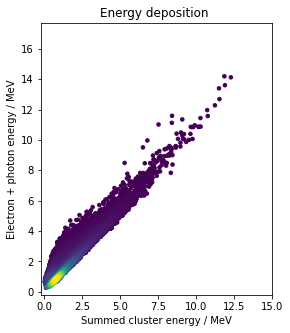

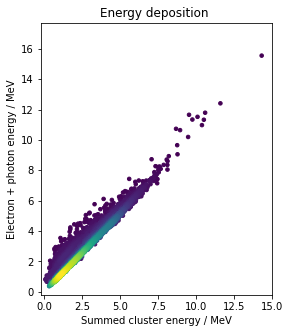

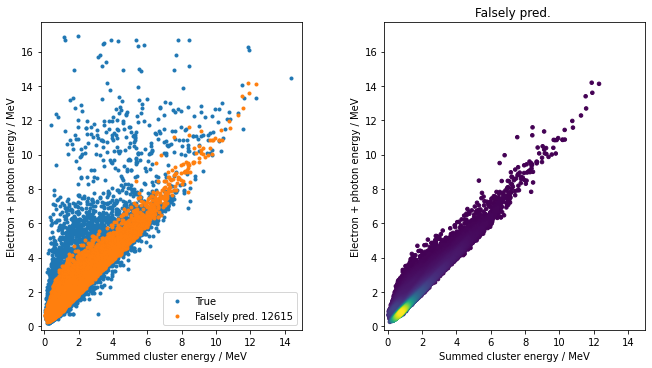

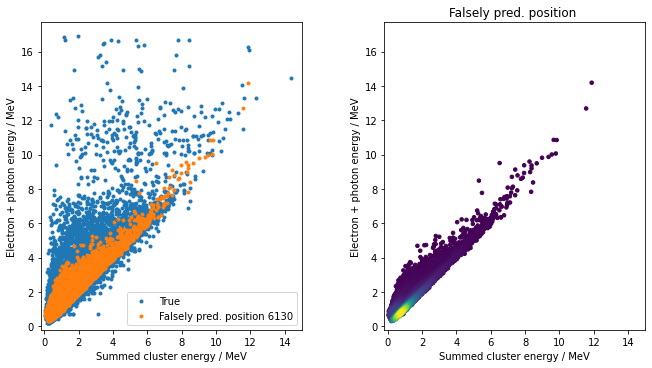

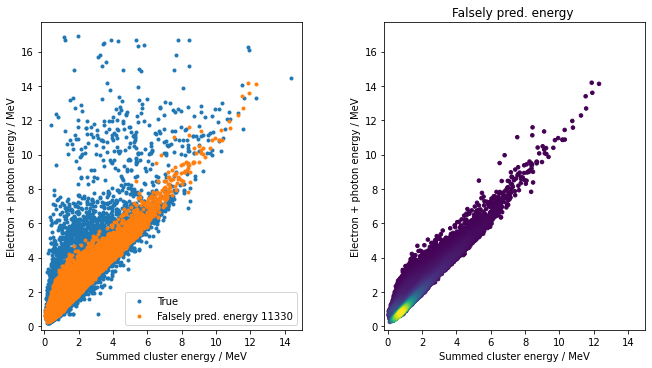

 Prediction of x positions 
15378.00000 Matched type number 
9248.00000 Matched position number 
9248.00000 Matched position number and matched type
 0.60138 Matched position from matched type 
   14881 Pred e in scatterer 
     441 Pred p in scatterer 
   14615 Matched e in scat 
     360 Matched p in scat 
   14734 True e in scatterer 
     644 True p in scatterer 
     644 True e in abs 
   14734 True p in abs 
     443 Pred e in abs 
   14809 Pred p in abs 
     360 Matched e in abs 
   14549 Matched p in abs 



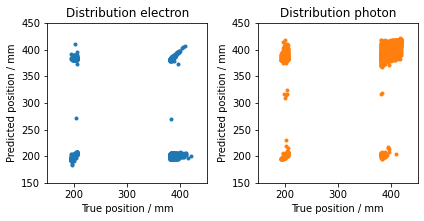

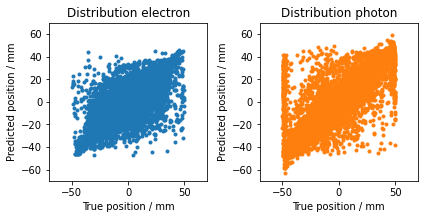

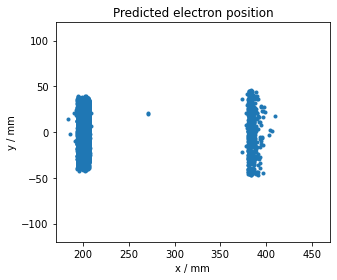

In [12]:
#ai.savefigpath = '/some/path/'
ai.events_prediction_analysis(plots = 'all-events', save = False)

 0.15017 Total efficiency
 0.13774 Total purity
 65668 All valid events
  2763 Correctly recon./ident. events
 18399 All true Compton events
 20059 NN pred Compton events
 15378 NN type-matched events
Eff scat 0.05592695255176912
Eff clus 0.0560356541116365
No Eff scat 10748.0
No Eff cl 10774.0
No Eff scat type match 8464
No Eff cl   type match 8485


/.automount/home/home__home2/institut_3b/profe/Software/DeepLearning/neural-network/sificc_lib/AI.py:1367: RuntimeWarning: invalid value encountered in true_divide
  purity = np.sum(l_matches_length) / np.sum(y_pred[:,0])



 44538 events for 1 cluster matches in scat from  65668 events
  2660 matched events for 1 cluster matches in scat 
0.14457307 efficiency, 0.13780241 purity fo 1 cluster matches in scat 

 12831 events for 2 cluster matches in scat 
    86 matched events for 2 cluster matches in scat 
0.00467417 effiecency, 0.14075286 purity fo 2 cluster matches in scat 


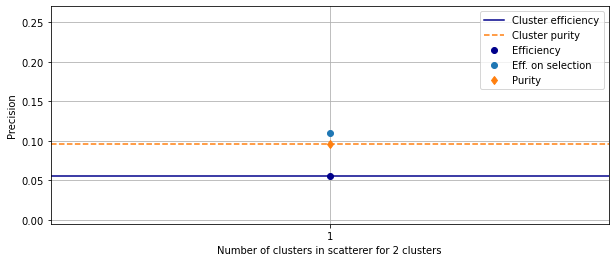

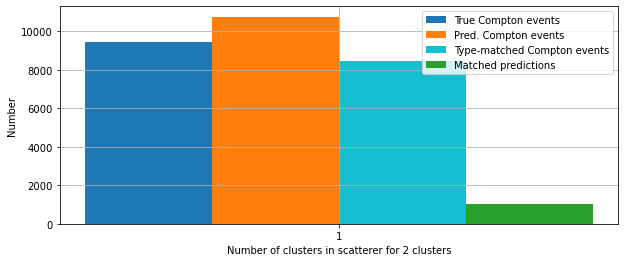

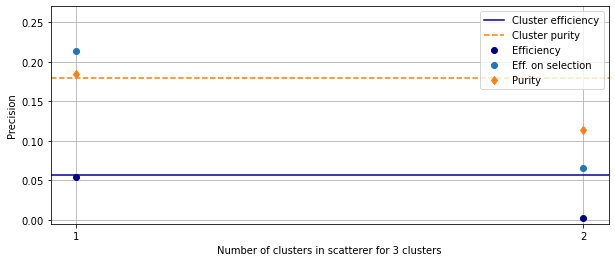

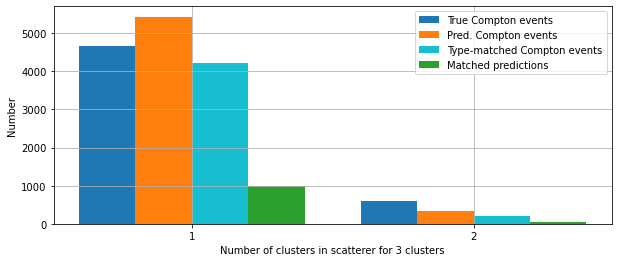

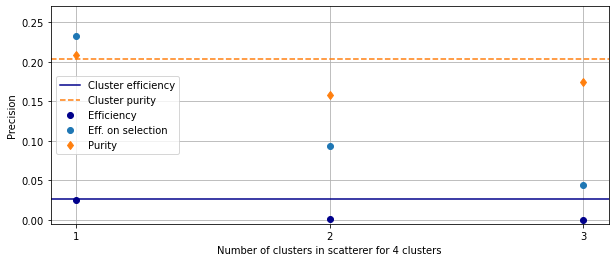

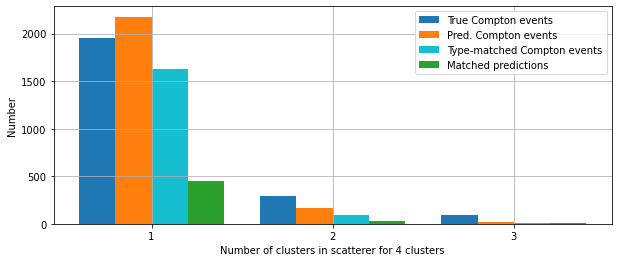

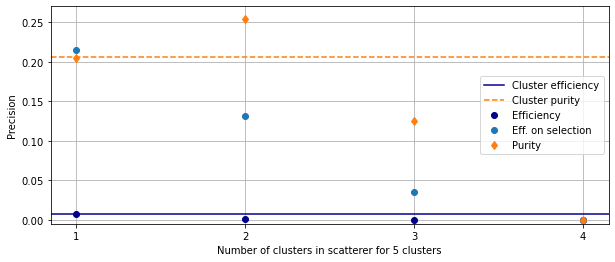

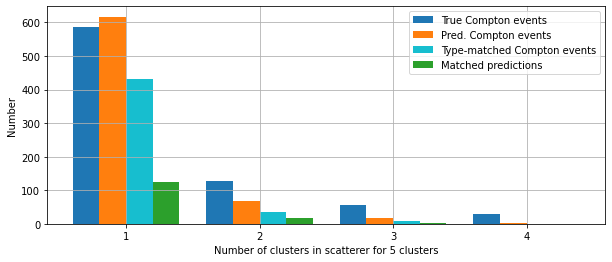

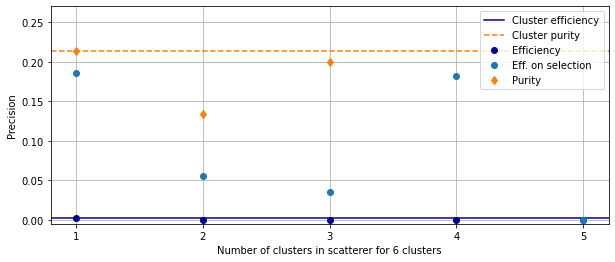

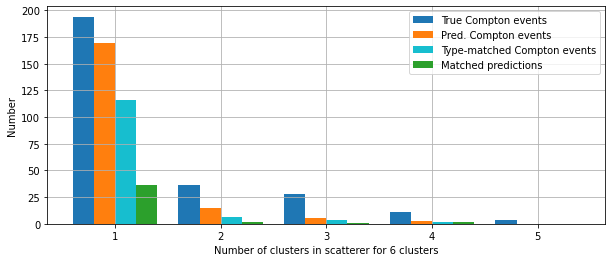

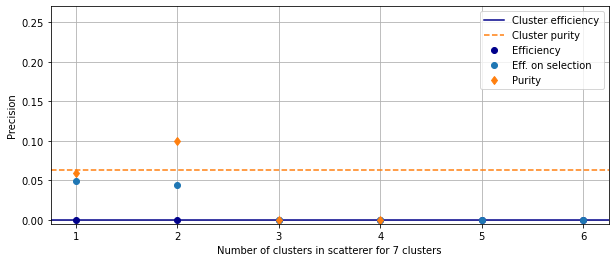

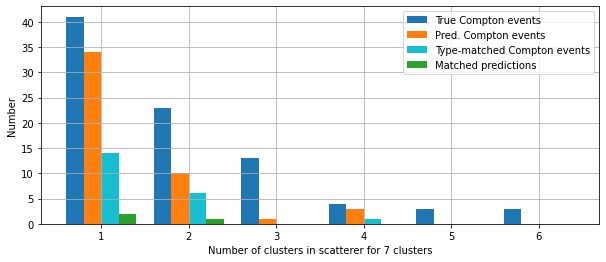

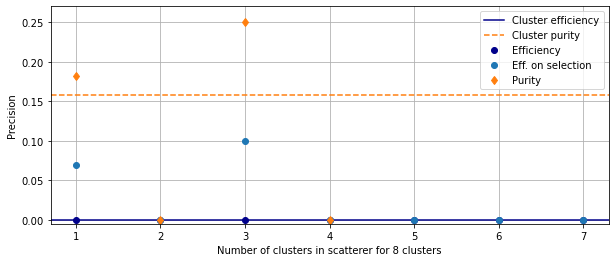

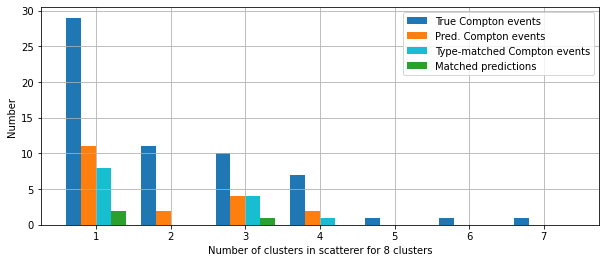

In [13]:
ai.events_prediction_analysis(plots = 'cluster-distribution', save = False)

In [14]:
#ai.events_prediction_analysis(plots = 'cluster-numbers', save = False)